# Alexnet Model 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import cv2
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn import metrics
import itertools
import re
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
#loading the saved file once again
tumor_final = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code','features.npy'), 
                allow_pickle=True)

#loading the saved file once again
target = np.load(os.path.join('/Users/balaj/OneDrive/Desktop/Docs/Docs 1/SMU/Capstone A/Code','target.npy'), 
                allow_pickle=True)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(tumor_final, target, test_size=0.2, random_state=42)

print(pd.DataFrame(Y_test)[0].value_counts())

print(pd.DataFrame(Y_train)[0].value_counts())

# random shuffling the training images and target
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = np.array(Y_train)[s]

# random shuffling the Test images and target
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = np.array(Y_test)[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

1    266
0    137
Name: 0, dtype: int64
1    1124
0     486
Name: 0, dtype: int64


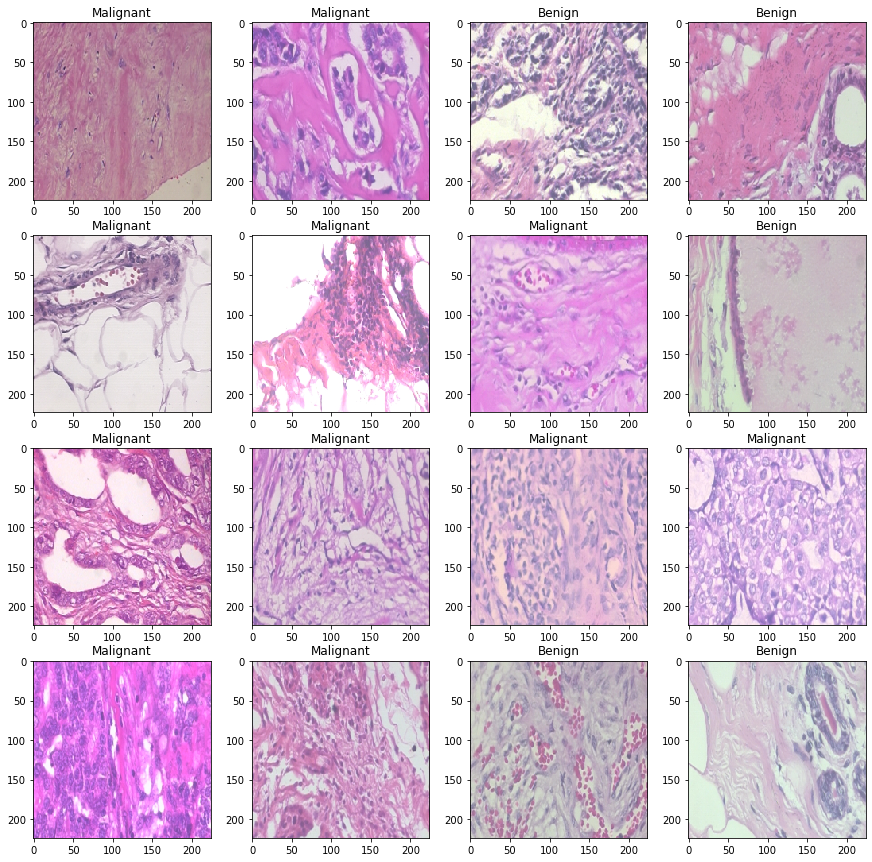

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [5]:
from IPython.display import Image
from IPython.display import display
x=Image(url="images/alexnet.png", width=600)
y=Image(url="images/alexnet2.png", width=600)
display(x, y)

In [6]:
def alex_net(input_shape=(64, 64, 3),classes=2):
    
    img_rows, img_cols = 224, 224   # by default size is 224,224
    img_channels = 3

    img_dim = (img_rows, img_cols, img_channels)
   
    img_input = Input(shape=img_dim)
    
    x = Conv2D(96, (11, 11), activation='relu', strides= 4, padding='valid')(img_input)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    
    x = Conv2D(256, (5, 5), activation='relu', strides= 1, padding='same')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    
    x = Conv2D(384, (3, 3), activation='relu', strides= 1, padding='same')(x)
    
    x = Conv2D(384, (3, 3), activation='relu', strides= 1, padding='same')(x)
        
    x = Conv2D(256, (3, 3), activation='relu', strides= 1, padding='same')(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    
    x = Flatten(name='flatten')(x)
    
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    
    x = Dense(classes, activation='softmax')(x)
    
    # Create model. 
    model = Model(inputs = img_input, outputs = x, name='VGGdemo')

    return model

In [7]:
# Create the model
alexnet_model = alex_net(input_shape = (224, 224, 3), classes = 2)
print(alexnet_model)

In [8]:
lr=1e-4
alexnet_model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

alexnet_model.summary()

Model: "VGGdemo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       8851

In [9]:
# Generate batches of tensor image data with real-time data augmentation.

BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range=0.7,
        brightness_range=[0.2,0.6]
    )

In [10]:
# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Callback to save the Keras model or model weights at some frequency.
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = alexnet_model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/2
80/80 [==============================] - 335s 4s/step - loss: 1.0331 - accuracy: 0.7461 - val_loss: 1.2293 - val_accuracy: 0.5745 - lr: 1.0000e-04
Epoch 2/2
80/80 [==============================] - 294s 4s/step - loss: 0.4593 - accuracy: 0.8175 - val_loss: 0.5591 - val_accuracy: 0.8696 - lr: 1.0000e-04


<AxesSubplot:>

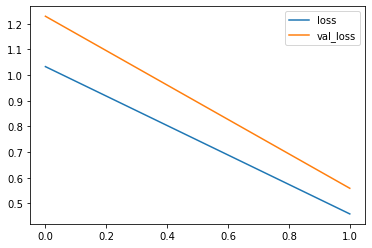

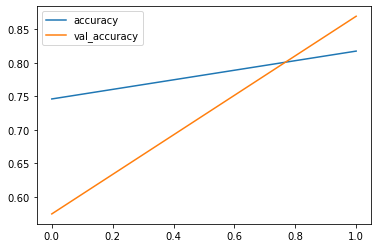

In [11]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

In [12]:
y_pred=alexnet_model.predict(X_test)


In [13]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))


              precision    recall  f1-score   support

           0       0.90      0.73      0.81       137
           1       0.87      0.96      0.91       266

    accuracy                           0.88       403
   macro avg       0.89      0.84      0.86       403
weighted avg       0.88      0.88      0.88       403



Confusion matrix, without normalization
[[100  37]
 [ 11 255]]


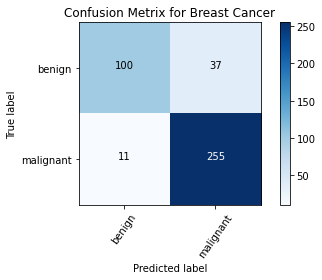

In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Breast Cancer')

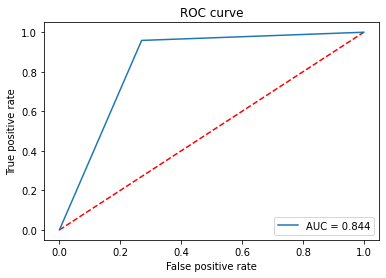

In [15]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()